In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from pandas.plotting import scatter_matrix

%matplotlib inline

import networkx as nx
from networkx.algorithms import bipartite

## 1. Propensity score matching

In [2]:
data = pd.read_csv('lalonde.csv')
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Observational study
We have 2 groups: "treated" vs "control"
The question is: was the treatment effective on the worker? That is, did it improved his earnings? did it depend on any of the other variables? (age, origin, marriage, education)
We need a way to measure effectiveness based on change in earnings

treatment assignment: Z = 1 (treated) and Z = 0 (control) -> treat
response if subject is treated: r_t -> how re78 differs from re74 and re75 (Z=1)
response if subject is control: r_c -> how re78 differs from re74 and re75 (Z=0)
observed covariates (features x) -> age, educ, black, hispan, married, nodegree
unobserved covariates ->  Naive model: exclude them because assume “Only observed variables determine treatment assignment”. Bad, naive model is almost never true. -> Use propensity score.
"Adjustments using a model attempt to compare people who are not directly
comparable — people of somewhat different ages or smoking habits — removing
these differences using a mathematical structure that has elements estimated from
the data at hand."


Propensity score -> "if naive model is true, it equals the probability to treat"
e(x) = P(Z=1|x)
Computed by logistic regression. Features x, label Z



In [3]:
# check the shape of the DataFrame
data.shape

(614, 11)

In [31]:
# Divide the dataset based on group (people who received the treatment vs control)
treated = data[data['treat'] == 1].reset_index()
control = data[data['treat'] == 0]

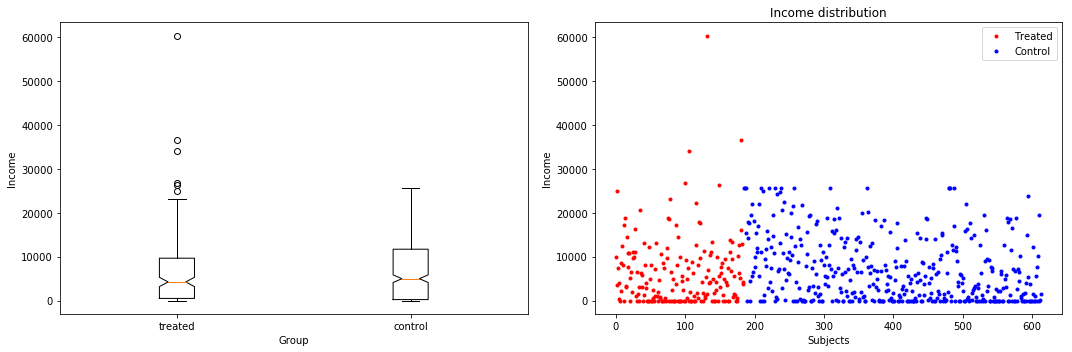

In [32]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(5,2,1)

# Boxplot of the two groups
data_to_plot = [treated.loc[:,'re78'], control.loc[:,'re78']]
plot = plt.boxplot(data_to_plot, 1)
plt.ylabel('Income')
plt.xlabel('Group')
plt.xticks([1, 2], ['treated', 'control'])

# Distribution of income (post-treatment)
plt.subplot(1,2,2)
plt.plot(treated.loc[:,'re78'],'.r')
plt.plot(control.loc[:,'re78'],'.b') 
plt.ylabel('Income')
plt.xlabel('Subjects')
plt.legend(['Treated','Control'])
plt.title('Income distribution')

# Plot all the variables, treated vs not treated
fig = plt.figure(figsize=(15, 8))
plt.subplot(3,2,1)
plt.plot(data[data['treat'] == 0].loc[:,'educ'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'educ'],'.b')
plt.ylabel('Years of Education')
plt.xlabel('Subjects')
plt.legend(['Treated','Control'])
plt.title('Age demographics')

plt.tight_layout()

Looking at the first plot, it seems that the treated people present a lower mean income (even though the difference in is not significant). From this first naive analysis it looks like the treatment is ineffective or even armful for incomes. But we should not forget . We should ask the following questions: 
* Do the two groups come from the same social status?
* Where they having the same income before the treatment?

The answer to both questions, as we are going to see soon, is no.
 
Now, let's see how other pre-treatment variables influence the probability to be treated.

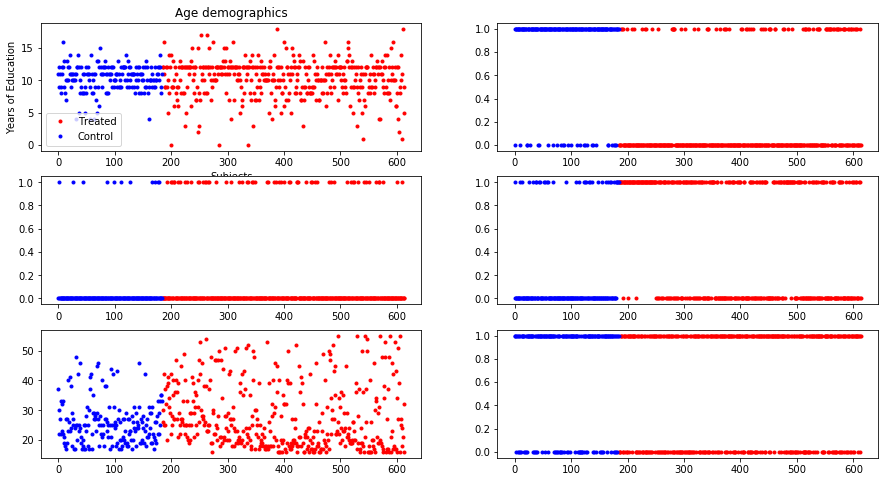

In [30]:
# Plot all the variables, treated vs not treated
fig = plt.figure(figsize=(15, 8))
plt.subplot(3,2,1)
plt.plot(data[data['treat'] == 0].loc[:,'educ'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'educ'],'.b')
plt.ylabel('Years of Education')
plt.xlabel('Subjects')
plt.legend(['Treated','Control'])
plt.title('Age demographics')

plt.subplot(3,2,2)
plt.plot(data[data['treat'] == 0].loc[:,'black'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'black'],'.b')
plt.subplot(3,2,3)
plt.plot(data[data['treat'] == 0].loc[:,'hispan'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'hispan'],'.b')
plt.subplot(3,2,4)
plt.plot(data[data['treat'] == 0].loc[:,'married'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'married'],'.b')
plt.subplot(3,2,5)
plt.plot(data[data['treat'] == 0].loc[:,'age'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'age'],'.b')
plt.subplot(3,2,6)
plt.plot(data[data['treat'] == 0].loc[:,'nodegree'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'nodegree'],'.b')

But if we look at the two groups seem to be **unbalanced**. For example, the majority of the treated people are young and black.

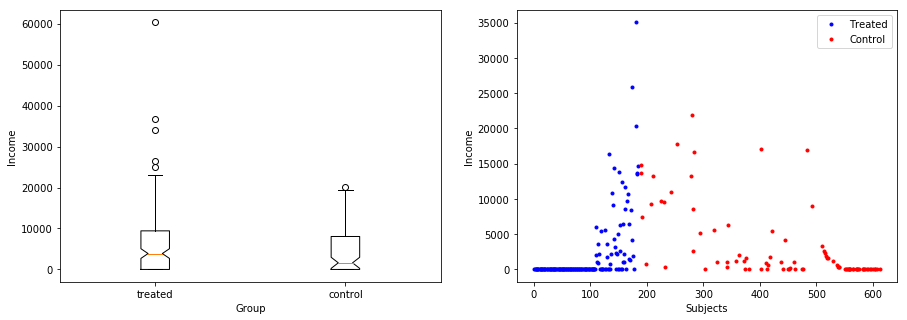

In [6]:
# Plotting the resulting income for only black people, before and after the treatment
fig = plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
data_to_plot = [treated[treated['black']==1].loc[:,'re78'], control[control['black']==1].loc[:,'re78']]
plot = plt.boxplot(data_to_plot,1)
plt.ylabel('Income')
plt.xlabel('Group')
plt.xticks([1, 2], ['treated', 'control'])

plt.subplot(1,2,2)
plt.plot(treated[treated['black']==1].loc[:,'re74'],'.b')
plt.plot(control[control['black']==1].loc[:,'re74'],'.r')
plt.ylabel('Income')
plt.xlabel('Subjects')
plt.legend(['Treated','Control'])

Looking at the boxplots we can start noticing a certain difference in the means of the two groups. This supports the hypothesis that

We are going to use the propensity score to match the nodes of a bipartite graph where the nodes correspond to the two groups.

In [7]:
# We can't do a t-test because the populations have different sizes.
#import scipy.stats as stats

#We want to test if the medians differ significantly
#stats.ttest_rel(a = treated[treated['black']==1].loc[:,'re78'],
 #               b = no_treated[no_treated['black']==1].loc[:,'re78'])

## Propensity score
At this point, we need to interpolate the data in order to obtain two populations of the same size. To do so, we are going to match the data the propensity score. Under the assumption that only observed variables determine treatment assignment, the propensity score represents the probability of receiving the treatment, given the pre-treatement features.

Our pre-treatment features are: ...

In [8]:
#features and labels
X = data.drop(['id', 'treat','re78'],axis=1)
y = np.array(data.treat)

In [9]:
logistic = linear_model.LogisticRegression()  # create the model
logistic.fit(X, y)  # train it

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the model performs. For this we will implement an error function which balances the two classes.

In [10]:
#Predict
yhat = cross_val_predict(logistic, X, y, cv=5)

#Check the class error
classes = np.unique(y);
err = np.zeros(len(classes));

for c in range(len(classes)):
    err[c] = sum((y!=yhat) & (y == classes[c]))/sum(y==classes[c]);

err = np.mean(err);
err

0.31607761607761609

In [11]:
# Select only the probability to be treated (1)
data['propens'] = logistic.predict_proba(X)[:,1]

## Matching
Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
Maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

In [12]:
B_treated = list(treated.id)
B_control = list(control.id)

In [13]:
# let's create a graph
B = nx.Graph()
B.add_nodes_from(B_treated, bipartite=0)
B.add_nodes_from(B_control, bipartite=1)

In [14]:
%%time
for b_treated in B_treated:
    for b_control in B_control:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_control)].propens.values)
        B.add_edge(b_treated,b_control,weight = wt)

CPU times: user 1min 40s, sys: 1.46 s, total: 1min 41s
Wall time: 1min 41s


In [ ]:
print('Nodes:', len(B.nodes()))
print('Edges:', len(B.edges()))
print('The total number of edges correspond to', len(B_treated), '(N treated) *', len(B_control),  '(N control)')

Nodes: 614
Edges: 79365
The total number of edges correspond to 185 (N treated) * 429 (N control)


In [ ]:
%%time
d = nx.algorithms.max_weight_matching(B,maxcardinality=True)

In [ ]:
df = pd.DataFrame()
for key in d.keys():
    df = pd.concat([df, data[data['id']==key]])

In [ ]:
df_t = df[df['treat']==1]
df_nt = df[df['treat']==0]
data_to_plot = [df_t[data['nodegree']==0].loc[:,'re78'], df_nt[data['nodegree']==0].loc[:,'re78']]
plot = plt.boxplot(data_to_plot)